#### Тестрование label propagation на графах с сообществами (SBM)

Метрика качества -- вес максимального паросочетания в двудольном графе "настоящих сообществ" и найденных сообществ, где вес ребра -- количество общих вершин, делённый на количество вершин (максимальное возможное значение).

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import quality_functions as qf

from utils import parse_6dfb, parse_twitter
from utils import gen_sbm_graph, label_propagation, quality_of_partition, sizes_to_partition, w_label_prop

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


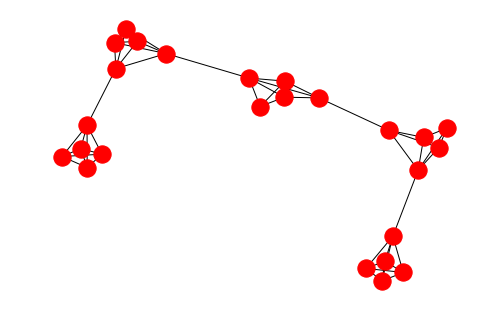

In [2]:
G = gen_sbm_graph([5 for i in range(5)], prob_community=0.97, prob_other=0.03)
nx.draw(G)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


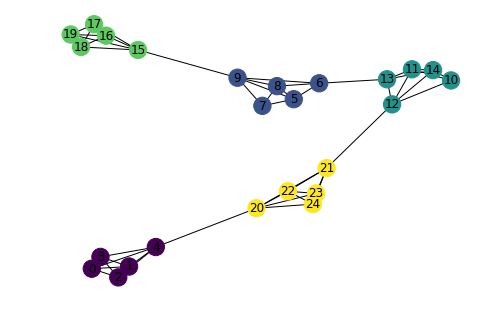

In [3]:
def draw_partition(graph, partition):
    dct = dict(zip(set(partition), range(len(set(partition)))))
    colors = [dct[i] for i in partition]
    nx.draw(graph, node_color=colors, with_labels=True)
    
partition, deltas = w_label_prop(G, min_delta=1)
draw_partition(G, partition)

Зависимость качества от вероятности ребра внутри сообщества и между ними (выбираются как $\alpha$ и $1-\alpha$)

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


1.0

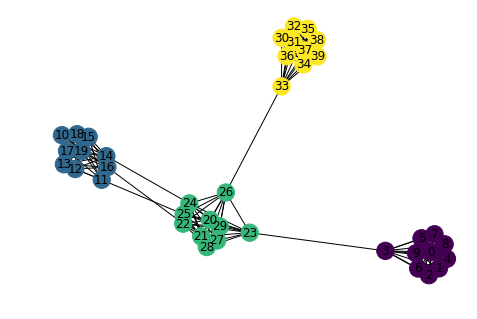

In [4]:
def get_quality(sizes, p1, p2, draw=True, min_delta=1):
    true_partition = sizes_to_partition(sizes)
    graph = gen_sbm_graph(sizes, p1, p2)
    partition, _ = label_propagation(graph, min_delta=min_delta)
    if draw: draw_partition(graph, partition)
    return quality_of_partition(true_partition, partition)


def get_comm_number(sizes, p1, p2, draw=True, min_delta=1):
    graph = gen_sbm_graph(sizes, p1, p2)
    partition, _ = w_label_prop(graph, min_delta=min_delta)
    return len(set(partition))


def test_function(alphas, f, n_measures=3):
    means, devs = [], []
    for alpha in alphas:
        results = [f([100 for i in range(20)], p1=1-alpha, p2=alpha, draw=False) for i in range(n_measures)]
        results = np.array(results)
        means.append(results.mean())
        devs.append(results.std())
    return means, devs

get_quality([10 for i in range(4)], 0.98, 0.01)

CPU times: user 1min 1s, sys: 982 ms, total: 1min 2s
Wall time: 1min 2s


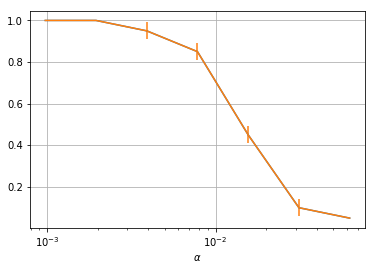

In [5]:
%%time

plt.xlabel('$\\alpha$')
plt.xscale('log')
plt.grid(True)
alphas =  2. ** np.arange(-10, -3)
means, devs = test_function(alphas, get_quality)
plt.plot(alphas, means)
plt.errorbar(alphas, means, devs)

CPU times: user 1min 6s, sys: 1.92 s, total: 1min 8s
Wall time: 1min 29s


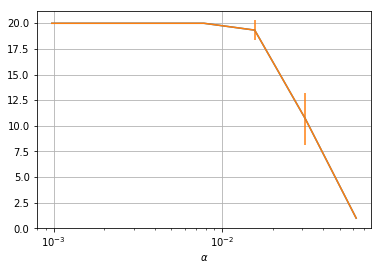

In [6]:
%%time

plt.xlabel('$\\alpha$')
plt.xscale('log')
plt.grid(True)
means, devs = test_function(alphas, get_comm_number)
plt.plot(alphas, means)
plt.errorbar(alphas, means, devs)

### Тестирование на датасетах

In [7]:
%%time
g_6dfb = parse_6dfb()

CPU times: user 48.8 s, sys: 247 ms, total: 49.1 s
Wall time: 49.4 s


In [8]:
%%time

from collections import Counter

partition, deltas = label_propagation(g_6dfb, max_iter=10**3, min_delta=200)
print(len(deltas), 'iterations')

33 iterations
CPU times: user 22.3 s, sys: 3.81 ms, total: 22.3 s
Wall time: 22.3 s


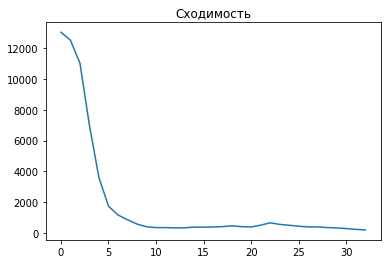

In [9]:
plt.title('Сходимость')
plt.plot(deltas)

2 сообщества по 6 тысяч, остальные сообщества довольно небольшие:

In [10]:
Counter(partition).most_common(10)

[(1, 6499),
 (0, 6416),
 (242, 6),
 (809, 4),
 (45, 2),
 (676, 2),
 (702, 2),
 (2, 1),
 (3, 1),
 (4, 1)]

In [11]:
def get_subgraph(partition, comm_ind, graph):
    new_ind = dict()
    for i in range(len(partition)):
        if partition[i] == comm_ind:
            new_ind[i] = len(new_ind)
    subgraph = nx.Graph()
    for i in range(len(new_ind)):
        subgraph.add_node(i)
    for v1, v2 in graph.edges():
        try:
            v1, v2 = new_ind[v1], new_ind[v2]
            subgraph.add_edge(v1, v2)
        except:
            pass
    return subgraph

6499 73963
[(0, 6481), (1, 12), (2, 1), (3, 1), (4, 1)]
6416 80622
[(1, 5529), (0, 706), (2, 150), (3, 4), (21, 2)]
CPU times: user 8.82 s, sys: 76.3 ms, total: 8.9 s
Wall time: 8.89 s


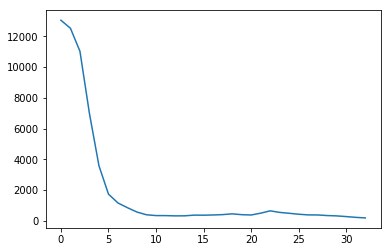

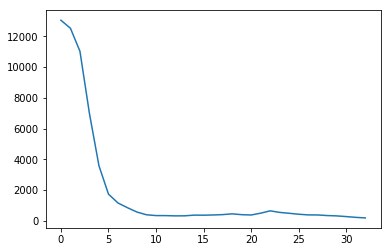

In [12]:
%%time

inds = dict(Counter(partition).most_common(2)).keys()

for ind in inds:
    subgraph = get_subgraph(partition, ind, g_6dfb)
    print(subgraph.number_of_nodes(), subgraph.number_of_edges())
    s_partition, s_deltas = label_propagation(subgraph, max_iter=50, min_delta=100)
    print(Counter(s_partition).most_common(5))
    plt.figure()
    plt.plot(deltas)

#### Распределение даты рождения в каждой из двух больших компонент и во всех остальных.

(array([139., 314., 399., 507., 423., 380., 258., 126., 114., 226.]),
 array([1389. , 1420.1, 1451.2, 1482.3, 1513.4, 1544.5, 1575.6, 1606.7,
        1637.8, 1668.9, 1700. ]),
 <a list of 10 Patch objects>)

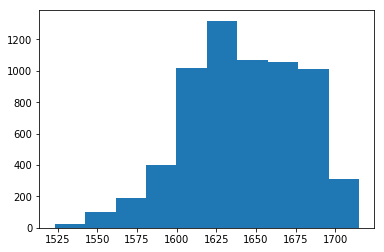

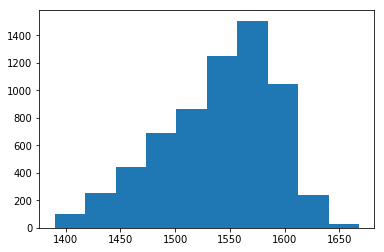

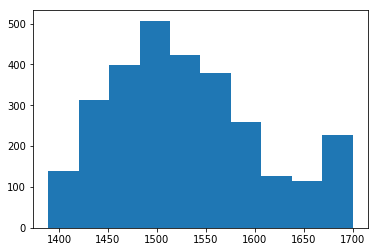

In [13]:
years = pd.read_csv('6dfb/SDFB_people.csv')['Extant Birth Year']
years_int = []
for i in years: 
    if len(i) != 4:
        i = i[-4:]
    years_int.append(int(i))
years = np.array(years_int)

partition = np.array(partition)
indexes_other = (partition == partition)
for ind in inds:
    plt.figure()
    plt.hist(years[partition == ind])
    indexes_other = indexes_other & (partition != ind)

plt.figure()
plt.hist(years[indexes_other])

[(10641, 5176),
 (15404, 4134),
 (14465, 3064),
 (0, 2765),
 (15292, 498),
 (14802, 26),
 (2620, 11),
 (10214, 6),
 (6730, 5),
 (4169, 4)]

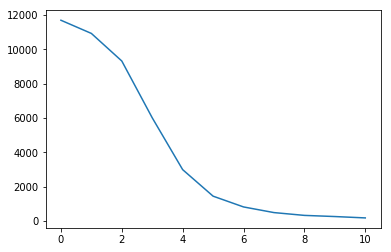

In [14]:
partition, deltas = w_label_prop(g_6dfb, max_iter=10**3, min_delta=200)
plt.plot(deltas)
Counter(partition).most_common(10)

Аналогично для твиттера

In [15]:
from utils import parse_twitter
g_twitter = parse_twitter()

In [16]:
%%time
partition, deltas = label_propagation(g_twitter, max_iter=50, min_delta= 20 * 1000)
print(len(deltas), 'iterations')

50 iterations
CPU times: user 3min 27s, sys: 117 ms, total: 3min 27s
Wall time: 3min 27s


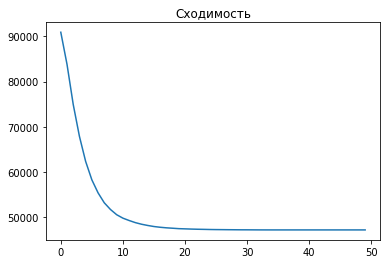

In [17]:
plt.title('Сходимость')
plt.plot(deltas)

In [18]:
Counter(partition).most_common(40)

[(277, 2391),
 (1292, 1201),
 (201, 1128),
 (282, 761),
 (284, 588),
 (1476, 532),
 (228, 427),
 (2831, 409),
 (113, 395),
 (2132, 374),
 (294, 370),
 (220, 353),
 (7350, 344),
 (5011, 299),
 (498, 267),
 (319, 259),
 (1761, 254),
 (2629, 252),
 (64, 237),
 (5962, 235),
 (6205, 219),
 (13374, 212),
 (1125, 210),
 (6, 209),
 (346, 188),
 (150, 186),
 (42212, 185),
 (361, 183),
 (5292, 180),
 (456, 173),
 (313, 172),
 (7042, 171),
 (202, 170),
 (17, 169),
 (203, 166),
 (2250, 164),
 (535, 162),
 (734, 157),
 (3174, 157),
 (11924, 157)]

In [19]:
Counter(Counter(partition).values()).values()

dict_values([303, 62244, 1, 6, 5, 1, 1, 4, 25, 45, 31, 4, 14, 1, 5, 115, 2, 3, 20, 9, 97, 37, 13, 1, 56, 1, 9, 6, 1, 1, 11, 16, 1597, 167, 38, 1, 1, 1, 4, 1, 8, 61, 1, 5, 24, 1, 3, 2, 17, 1, 1, 1, 11, 1, 1, 1, 3, 1, 1, 18, 2, 4, 4, 3, 4, 8, 1, 5, 5, 22, 2, 1, 47, 14, 13, 3, 1, 1, 6, 3, 1, 5, 6, 3, 1, 10, 3, 17, 4, 85, 1, 2, 29, 2, 4, 73, 1, 1, 19, 31, 2, 4, 1, 1, 27, 2, 4, 1, 5, 1, 10, 2, 3, 1, 1, 1, 1, 2, 1, 1, 1, 4, 2, 1, 4, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1])

(array([6.5125e+04, 2.6600e+02, 8.8000e+01, 4.8000e+01, 3.0000e+01,
        1.9000e+01, 6.0000e+00, 1.3000e+01, 9.0000e+00, 2.8000e+01]),
 array([  1. ,  20.9,  40.8,  60.7,  80.6, 100.5, 120.4, 140.3, 160.2,
        180.1, 200. ]),
 <a list of 10 Patch objects>)

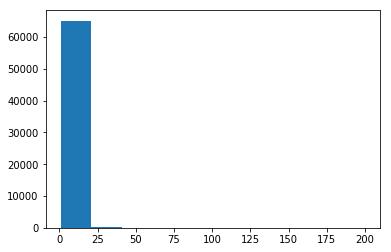

In [20]:
sizes = np.array(list(Counter(partition).values()))
plt.hist(np.minimum(sizes, 200))

(array([40., 15.,  6.,  3.,  4.,  1.,  1.,  1.,  0.,  4.]),
 array([101. , 165.9, 230.8, 295.7, 360.6, 425.5, 490.4, 555.3, 620.2,
        685.1, 750. ]),
 <a list of 10 Patch objects>)

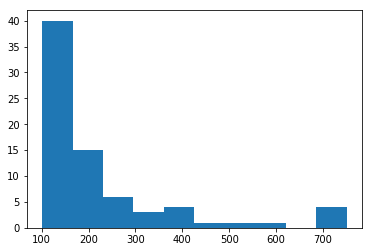

In [21]:
sizes1 = []
for i in sizes:
    if i > 100:
        sizes1.append(i)
plt.hist(np.minimum(sizes1, 750))